# Demo de implementación de un algoritmo de Colonia de Abejas (Bee Algorithm) para resolver el problema de encontrar un Máximo Óptimo  definido al azar en un plano y tratando de esquivar  los máximos locales aleatorios


1) Importar librerías:

In [1]:
#@title
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import operator
print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [2]:
# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3 #@param {type:"slider", min:0, max:10, step:1}

# Espacio mínimo y máximp del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000 #@param {type:"slider", min:-1000, max:0, step:5}
MAX_ESPACIO_BUSQ = 1000 #@param {type:"slider", min:0, max:1000, step:10}

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 50 #@param {type:"integer"}

# Cantidades para  Abejas Exploradoras
CANT_ABEJAS_EXPLORADORAS = 5 #@param {type:"slider", min:1, max:25, step:1}
CANT_MEJORES_ABEJAS_RECLUTAN = 3 #@param {type:"slider", min:1, max:10, step:1}
CANT_ABEJAS_OBRERAS_RECL_ELITE = 5 #@param {type:"slider", min:1, max:20, step:1}
CANT_ABEJAS_OBRERAS_RECL_NORMAL = 2 #@param {type:"slider", min:0, max:10, step:1}

#  Área de las Abejas Exploradoras
RADIO_AREA_EXPLORADORA = 50 #@param {type:"slider", min:1, max:100, step:1}
PORC_RED_AREA_EXPLORADORA = 0.5  #@param {type:"slider", min:0, max:1, step:0.05}
MIN_RADIO_AREA_EXPLORADORA = 2 #@param {type:"slider", min:1, max:100, step:1}

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True #@param {type:"boolean"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Especificar el objeto Abeja y la Función Heurística:

In [3]:
#@title clase MAPA DE BÚSQUEDA

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)


print("\nClase Mapa de Búqueda definida") 


# Define el Mapa de Búsqueda
mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    cantMaximosLocales=CANT_MAXIMOS_LOCALES)

print("\nMapa de búsqueda definido")


Clase Mapa de Búqueda definida

Mapa de búsqueda definido


In [4]:
#@title clase ABEJA

class Abeja(object):
    
    def __init__(self, mapa=None, radioArea=0):
        
        if mapa == None:
            self.pos = []
            self.radio = 0
            self.valor = -9999
        else:        
            self.pos = [random.randint(mapa.limMin, mapa.limMax) for _ in range(2)]
            self.valor = mapa.funcHeuristica(self.pos)
            self.radio = radioArea

    def _reset(self):
        self.pos = []
        self.radio = 0
        self.valor = -9999

    @property
    def heuristica(self):
        return round(self.valor, 2)

    @property
    def posicion(self):
        return self.pos    

    @property
    def tieneArea(self):
        return self.radio>0 

    def reclutarObreras(self, mapa, cantObrerasReclutadas, \
                        radioAreaExpl=RADIO_AREA_EXPLORADORA, porcRedAreaExpl = PORC_RED_AREA_EXPLORADORA, minAreaExpl=MIN_RADIO_AREA_EXPLORADORA):
        
        # Si el radio del área es nulo, no se generan
        if self.radio <= 0:
            return []

        obrerasReclutadasNuevas = []
        algunaObreraMejor = False
        for i in range(cantObrerasReclutadas):

              # Crea una nueva abeja a la que le asigna una posción relativa a la exploradora padre
              # y luego calcula su herística
              nOb = Abeja()
              for i in range(len(self.pos)):
                  nOb.pos.append( random.randint(int(self.pos[i]-self.radio), int(self.pos[i]+self.radio)) )
              nOb.valor = mapa.funcHeuristica(nOb.pos)
              
              if nOb.valor > self.valor:
                  # si la nueva obra es mejor que la padre, 
                  #    pasa a ser una exploradora
                  nOb.radio = radioAreaExpl
                  algunaObreraMejor = True

              obrerasReclutadasNuevas.append( nOb )
        
        if not algunaObreraMejor:
                # Cuando ninguna obrera es mejor, 
                #     se reduce el área de la abeja exploradora 
                self.radio = self.radio * (1-porcRedAreaExpl)
                if self.radio <= minAreaExpl:
                    self.radio = 0

        return obrerasReclutadasNuevas

    def hacerExploradoraArea(self, radioArea):
        self.radio = radioArea
        return self.radioArea

print("\nClase Abeja definida")


Clase Abeja definida


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [5]:
#@title EJECUCIÓN DE LA CORRIDA

# Muestra su información
mapa.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1
print("-- Mínima heurística para finalizar la Corrida: ", MIN_HEURISTICA_FINALIZAR, "--")

# vectores auxiliares 
ciclo = 1    
mejorAbeja = None
mejorAbejaCorrida = None
ciclosAbejas = []
ciclosMaxAptitud = []
beePobla = []

# Define las abejas exploradoras iniciales
ciclosAbejas.append( [] )
for i in range(CANT_ABEJAS_EXPLORADORAS):
  b = Abeja(mapa, radioArea=RADIO_AREA_EXPLORADORA)
  beePobla.append( b ) 
  ciclosAbejas[0].append( b.posicion )

# Finaliza cuando llegue a la cantidad de ciclos 
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorAbejaCorrida==None) or (mejorAbejaCorrida.heuristica<MIN_HEURISTICA_FINALIZAR)):

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)    
        print("  Cantidad de Abejas: ", len(beePobla) ) 

    # Evalúa las abejas exploradoras de la población para determinar las mejores con área disponible
    rankingAbejas = sorted([b for b in beePobla], key=operator.attrgetter('heuristica'), reverse=True)
    if len(rankingAbejas)>0:
        mejorAbeja = rankingAbejas[0]
        if mejorAbejaCorrida == None or mejorAbeja.heuristica > mejorAbejaCorrida.heuristica:
            mejorAbejaCorrida = mejorAbeja
        ciclosMaxAptitud.append( rankingAbejas[0].heuristica )

        # Realiza la reclutación de las abejas
        # pero  solo de las 'CANT_MEJORES_ABEJAS_RECLUTAN' mejores
        reclObreras = []        
        for exBee in rankingAbejas[:CANT_MEJORES_ABEJAS_RECLUTAN]:
              # Recluta las abejas obreras (cantidad elite para la mejor, normal el resto)
              if exBee == mejorAbeja:
                  auxReclObreras = exBee.reclutarObreras(mapa, CANT_ABEJAS_OBRERAS_RECL_ELITE)
              else:
                  auxReclObreras = exBee.reclutarObreras(mapa, CANT_ABEJAS_OBRERAS_RECL_NORMAL)

              # Agrega las nuevas abejas reclutadas
              if len(auxReclObreras)>0:
                  reclObreras.extend( auxReclObreras )

        # Agrega las nuevas abejas reclutadas a la población
        # si son nuevas exploradoras (i.e. tienen area)
        ciclosAbejas.append( [] )
        if len(reclObreras)>0:                            
            beePobla.extend( [b for b in reclObreras if b.tieneArea] )            
            ciclosAbejas[ciclo].extend([b.posicion for b in reclObreras])

    if MUESTRA_DETALLE:
        print("  Mejor Abeja:", mejorAbeja.posicion, " { ", mejorAbeja.heuristica, " } ")

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Abeja de la Corrida:", mejorAbejaCorrida.posicion, " { ", mejorAbejaCorrida.heuristica, " } ==")


** Máximos Generados:  4
  --> [-389, -328] {  34  } 
  --> [-183, -502] {  90  } 
  --> [-829, -900] {  16  } 
  --> [385, -783] {  53  } 

** Posición Máximo Óptimo:  [-183, -502]  {  90  } **


-- Mínima heurística para finalizar la Corrida:  89 --

-- Ciclo  1 --
  Cantidad de Abejas:  5
  Mejor Abeja: [367, -969]  {  34.31  } 

-- Ciclo  2 --
  Cantidad de Abejas:  10
  Mejor Abeja: [333, -922]  {  38.16  } 

-- Ciclo  3 --
  Cantidad de Abejas:  14
  Mejor Abeja: [366, -885]  {  42.62  } 

-- Ciclo  4 --
  Cantidad de Abejas:  18
  Mejor Abeja: [386, -840]  {  47.3  } 

-- Ciclo  5 --
  Cantidad de Abejas:  23
  Mejor Abeja: [419, -798]  {  49.28  } 

-- Ciclo  6 --
  Cantidad de Abejas:  25
  Mejor Abeja: [410, -784]  {  50.5  } 

-- Ciclo  7 --
  Cantidad de Abejas:  27
  Mejor Abeja: [389, -792]  {  52.02  } 

-- Ciclo  8 --
  Cantidad de Abejas:  28
  Mejor Abeja: [389, -792]  {  52.02  } 

-- Ciclo  9 --
  Cantidad de Abejas:  30
  Mejor Abeja: [382, -784]  {  52.68  } 

--

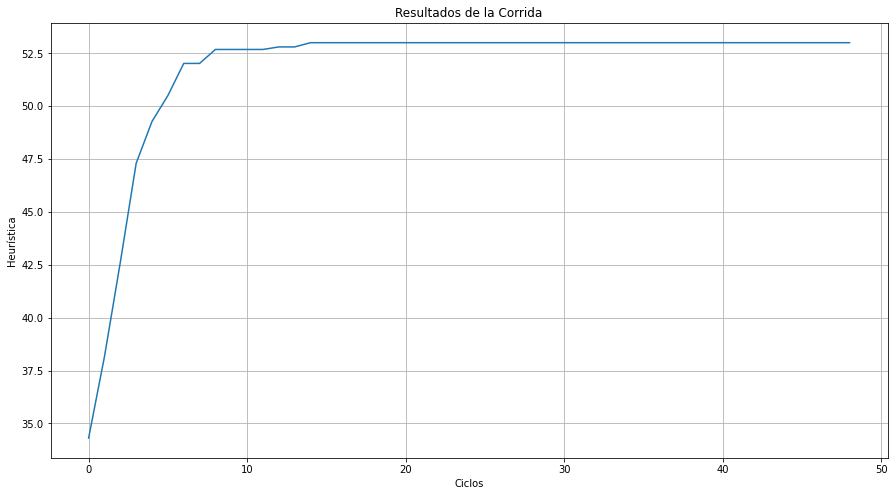

In [6]:
#@title  MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Heurística')
plt.grid(True)
plt.show()

In [7]:
#@title MOSTRAR GRAFICO DE POSICIONES DE LAS ABEJAS CICLO x CICLO

# Librerías especiales para usar
from matplotlib import animation, rc
from IPython.display import HTML

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = True
textoTitulo = "Ubicación de las Abejas ciclo x ciclo"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejor Abeja de la Corrida: ' + str(mejorAbejaCorrida.posicion) + ' { ' + str(round(mejorAbejaCorrida.heuristica, 3)) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (AZUL) - Máximo Óptimo (VERDE) - '  
textoDesc = textoDesc + '\n- Partículas (ROJO) - Mejor Partícula (VIOLETA) -- ' 
posMejorCorrida =  mejorAbejaCorrida.posicion
ax = None
ani = None

# Método que se ejecuta por cada frame para mostrar 
def updatePlot(i, ciclosPos, scat):

        if ax==None or ciclosPos==None:
            return scat,

        ax.set_xlabel('Ciclo: ' + str(i), fontsize=12)

          # Si no es el último ciclo, muestra también el global
        if i<len(ciclosPos): 
        
          if len(ciclosPos[i])>0:
             
              if MOSTRAR_HISTORICO_MOVIMIENTO:
                  # Coloca nuevas posiciones correspondientes al ciclo
                  # Separa las coordenadas x, y de las posiciones en el ciclo i
                  X, Y = zip(*ciclosPos[i])
                  ## --en Rojo: posiciones de las particulas de cada ciclo
                  scat = ax.scatter(X, Y, color='red')
              else:
                  # Hace mover a las Partículas
                  scat.set_offsets(ciclosPos[i])
        else:
               if posMejorCorrida != None:
                      ## --en Violeta: Mejor posición de las partículas
                      ax.scatter(posMejorCorrida[0], posMejorCorrida[1], color='violet', s=100)

        # Devuelve una lista de "artistas" para dibujar, 
        # en este caso es sólo uno por lo que se pone una coma final
        return scat,    

# Función para preparar el gráfico          
def PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos, textoTitulo="", textoDesc=""):          
      
      fig = plt.figure(figsize=(14,7))
      ax = fig.add_subplot(111)
      plt.close()

      ## -- en Azul: Máximos Locales (positivos)
      ## -- en Cyan: Mínimos Locales (negativos)
      ## -- en Verde: Máximo Óptimo
      for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
        if vali < 0:
            ax.scatter(posi[0], posi[1], color='cyan')
        else:
            ax.scatter(posi[0], posi[1], color='blue')
      ax.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)    

      # Define el tamaño de la figura
      ax.axis([MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ])

      # Separa las coordenadas x, y de las posiciones en el ciclo inicial
      X, Y = zip(*ciclosPos[0])
      ## --en Rojo: posiciones de las posiciones de cada ciclo
      scat = ax.scatter(X, Y, color='red')

      # Muestra título y texto debajo
      ax.set_title(textoTitulo)
      ax.set_ylabel(textoDesc, fontsize=11)

      # Luego setea la animación usando los dos métodos anteriores 
      cant = len(ciclosPos)+1
      ani = animation.FuncAnimation(fig, updatePlot, 
                                    frames=cant, interval=cant,
                                    fargs=(ciclosPos, scat), 
                                    blit=True, repeat=False)
      
      return ani, ax
    
# Prepara el gráfico 
ani, ax = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosAbejas, textoTitulo, textoDesc)    

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
ani


Output hidden; open in https://colab.research.google.com to view.

In [8]:
#@title EXPORTA EL GRAFICO ANTERIOR COMO UN VIDEO MP4
from google.colab import files

# Prepara el gráfico 
ani, ax = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosAbejas, textoTitulo, textoDesc)    

# Graba el gráfico anterior como un video MP4
nomArchi = "BEE Corrida.mp4"
ani.save('/' + nomArchi)
try: 
  files.download('/' + nomArchi)
  print('Video ' + nomArchi + ' generado, debería bajarse automaticamente como un archivo local...')
except ValueError:
  print('Error al intentar descargar el archivo ' + nomArchi)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Video BEE Corrida.mp4 generado, debería bajarse automaticamente como un archivo local...
